# K-Nearest Neighbors Classification

The dataset was obtained from https://archive.ics.uci.edu/ml/datasets/Iris.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from heapq import heappush, nsmallest
from collections import Counter

/home/pranaymethuku/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


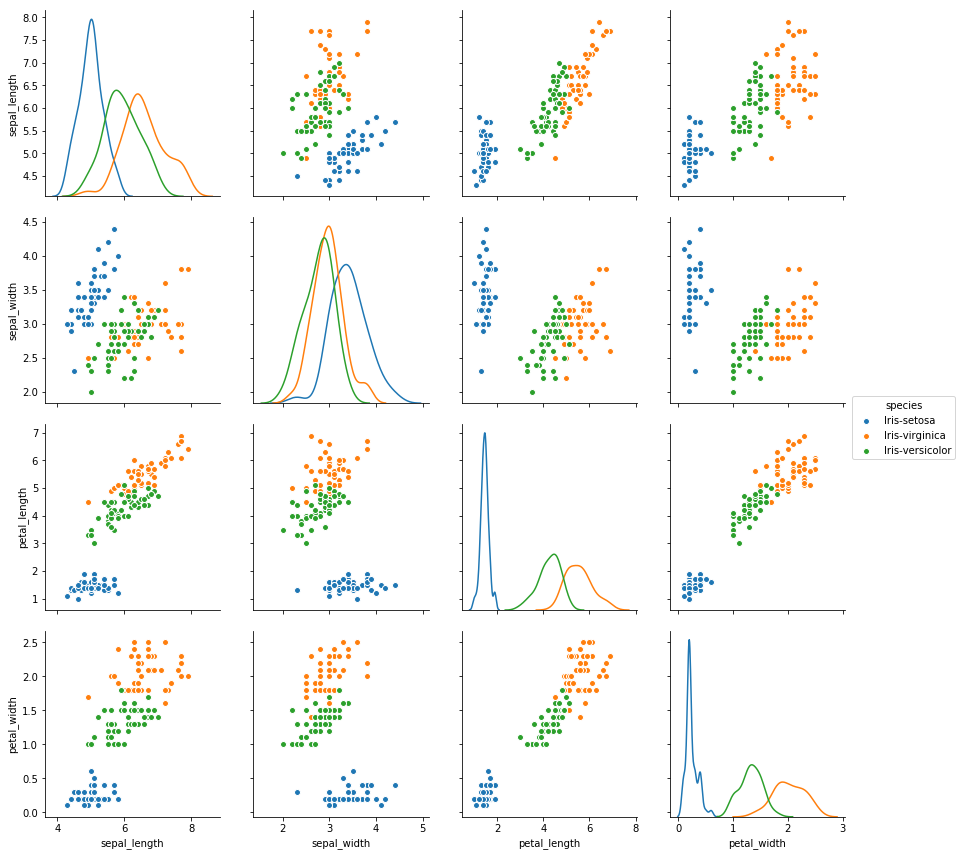

In [2]:
# read data and parse it
data = pd.read_csv('../datasets/iris_knn_classification.csv', 
                   names=["sepal_length","sepal_width","petal_length","petal_width","species"])
data = data.sample(len(data))
# Pair plots between features of different species
sns.pairplot(data, hue="species", size=3, diag_kind='kde')
label_id = {'Iris-setosa': 1, 'Iris-versicolor': 2, 'Iris-virginica': 3}
data['species'] = [label_id[x] for x in data['species']]

In [3]:
y = np.array(data['species'])
x = np.array(data.loc[:, data.columns != 'species'])

def split_data(x, y, ratio, fold=0):
    # Define the boundaries of the test data
    test_start = int(len(x) * ratio * fold)
    test_stop = int(len(x) * ratio * (fold+1))
    # Split the data
    train_x = np.concatenate((x[:test_start], x[test_stop:]))
    train_y = np.concatenate((y[:test_start], y[test_stop:]))
    test_x = x[test_start:test_stop]
    test_y = y[test_start:test_stop]
    return train_x, train_y, test_x, test_y

In [4]:
def cross_validate(x, y, folds, k):
    accuracies = []
    for fold in range(folds):
        train_x, train_y, test_x, test_y = split_data(x, y, 1./folds, fold)
        knn = KNN(train_x, train_y, k)
        accuracies.append(calculate_accuracy(knn.predict_batch(test_x), test_y))
    return np.mean(accuracies)

def calculate_accuracy(y_hat, y):
    return np.sum(np.equal(y, y_hat), dtype=float) / len(y)

In [5]:
class KNN:
    """ Implementation of the kNN classification algorithm """

    def __init__(self, X, Y, k):
        self.X = X
        self.Y = Y
        self.k = k

    def predict(self, input_x):
        """
        Predict labels using k-nearest neigbors for a given point.
        """
        neighbors = []
        for i in range(len(self.X)):
            heappush(neighbors, (self.distance(self.X[i], input_x), self.Y[i]))
        k_nearest = [x[1] for x in nsmallest(k, neighbors)]
        return Counter(k_nearest).most_common(1)[0][0]

    def predict_batch(self, X_test):
        """
        Predict labels using k-nearest neigbors for a batch.
        X_test : batch of inputs to predict
        """
        return [self.predict(point) for point in X_test]

    def distance(self,x1,x2):
        """ Calculate the distance between two points x1 and x2 """
        # L2 distance
        return sum((x1 - x2) ** 2) 
        # Manhattan distance
        # return sum(abs(x1 - x2)) 
        # negative Cosine similarity (cosine similarity is inversely proportional to distance)
        # return 1 - x1.dot(x2)/(np.linalg.norm(x1) * np.linalg.norm(x2))

In [6]:
train_x, train_y, test_x, test_y = split_data(x, y, ratio=0.25)
k_values = range(2, 80)
best_k = 1
best_acc = 0
for k in k_values:
    accuracy = cross_validate(train_x, train_y, folds=4, k=k)
    if k % 10 == 0:
        print("validation accuracy for k = {} is {:1.3f}".format(k, accuracy))
    if accuracy > best_acc:
        best_acc = accuracy
        best_k = k

# Use the best parameter
print("Checking accuracy on the test set using k = {}".format(best_k))
knn = KNN(train_x, train_y, best_k)
y_hat = knn.predict_batch(test_x)
test_acc = calculate_accuracy(test_y, y_hat)
print("Test set accuracy: {:1.3f}%".format(test_acc * 100))

validation accuracy for k = 10 is 0.956
validation accuracy for k = 20 is 0.955
validation accuracy for k = 30 is 0.947
validation accuracy for k = 40 is 0.911
validation accuracy for k = 50 is 0.832
validation accuracy for k = 60 is 0.611
validation accuracy for k = 70 is 0.513
Checking accuracy on the test set using k = 8
Test set accuracy: 83.784%
